#PROJET 3 Concevez une application au service de la santé publique

#APPLICATION - MODELISATION DU NUTRI-SCORE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

##Fonctions Outils

In [1]:
# FONCTIONS OUTILS : 

import numpy as np
import pandas as pd
 
#fonction pour nettoyer l'entrée
def nettoyage_dataset_une_entree(datafram):
 
  frame=datafram.copy()
  er1='Pas assez de donnée'
  er2='Erreur dans les données'
 
  #Vérification du taux de NaN 
  taux_Nan=frame.iloc[0].isnull().sum()/(len(frame.columns))*100
  if taux_Nan > 35:
    return er1
 
  #Vérification des entrées n'ayant que des valeurs nulles
  som_ind=frame.iloc[0].sum()
  if som_ind == 0 :
    return er1
 
  #Vérification des valeurs négatives (si valeur inf à 0 renvoi un NaN)
  data_work_nega=frame.copy()
  col_name1=['energy-kcal_100g',    'fat_100g', 'carbohydrates_100g',   'fiber_100g',   'proteins_100g',    'salt_100g']
  for col in col_name1:
    data_work_nega[col]=[val if val>=0 else np.NaN for val in data_work_nega[col]]
 
  #Vérification des valeurs suppérieur à 100g (si valeur sup à 100 renvoi un NaN)
  data_work_sup=data_work_nega.copy()
  col_name2 = ['fat_100g',  'carbohydrates_100g',   'fiber_100g',   'proteins_100g',    'salt_100g']
  for col in col_name2:
    data_work_sup[col]=[val if val<=100 else np.NaN for val in data_work_sup[col]]
 
  #Vérification de energy-kcal_100g borné au 99.5eme percentile (si valeur sup renvoi un NaN)
  data_work_nrj_pe=data_work_sup.copy()
  per_99=900 #valeur calculer sur le dataset training
  data_work_nrj_pe['energy-kcal_100g']=[val if val <= per_99  else np.NaN for val in data_work_nrj_pe['energy-kcal_100g']]
 
  #Vérification des entrées dont la somme de ses constituants est supérieur à 100g
  som_ind_const=frame.iloc[0,1:6].sum()
  if som_ind_const > 100 :
    err=er2+': somme des constituants supérieur à 100g'
    return err
 
  #Vérification du taux de NaN 
  taux_Nan2=data_work_nrj_pe.iloc[0].isnull().sum()/(len(data_work_nrj_pe.columns))*100
  if taux_Nan2 > 35:
    return er2
 
  #formatage du dataset cleané
  final_data=data_work_nrj_pe.copy()
  
  return final_data
 

 
 
#fonction pour prédire le nutrition score 
def nutrition_grade_mod(frame_a_pred,scaler_save,knn_save):
 
  frame=frame_a_pred.copy()
  
  from sklearn import neighbors
  from sklearn.preprocessing import StandardScaler
  import pickle
 
  #normalisation 
  scaler = pickle.load(open(scaler_save, 'rb'))
  scal_value=scaler.transform(frame)
  
  #data_set normé
  colon_name=['energy-kcal_100g',   'fat_100g', 'carbohydrates_100g',   'fiber_100g',   'proteins_100g',    'salt_100g']
  data_scal_frame=pd.DataFrame(scal_value,columns=colon_name)
  data_scal_frame=data_scal_frame.fillna(0)
 
  #prédiction du nutrition score
  knn = pickle.load(open(knn_save, 'rb'))
  predic_test = knn.predict(data_scal_frame)
 
  return predic_test
 


 
#fonction pour attriber le nutrition grade
def nutri_score_lettre_mod(frame):
  
  nutri_scor_letr = []
  
  for scor in frame['nutritionscore_mod']:
    
    if scor >= frame['nutritionscore_mod'].min() and scor <= -1:
      nutri_scor_letr.append('A')
    if scor >-1 and scor <= 4:
      nutri_scor_letr.append('B')
    if scor >4 and scor <= 12:
      nutri_scor_letr.append('C')
    if scor >12 and scor <= 17:
      nutri_scor_letr.append('D')
    if scor >17 and scor <= frame['nutritionscore_mod'].max():
      nutri_scor_letr.append('E')
  
  frame['nutriscore_grade'] = nutri_scor_letr
  
  return frame




#fonction modélisation nutrition grade
def modelisation_nutrition_grade():
    
  #Récupération des valeurs d'entrée
  NAME=input('Nom du produit :')
  NRJ=input('Energie (kcal pour 100g) :')
  GRAS=input('Gras (g pour 100g) :')
  SUCRE=input('Sucre (g pour 100g) :')
  FIBRE=input('Fibre (g pour 100g) :')
  PROT=input('Protéines (g pour 100g) :')
  SEL= input('Sel (g pour 100g) :')
 
  list_input =[NRJ,GRAS,SUCRE,FIBRE,PROT,SEL]
  list_input_i=[]
 
  for i in list_input:

    if i != '':
      list_input_i.append(float(i))
    elif i == '':
      list_input_i.append(np.NaN)
 
  #Formatage de l'entrée
  colon_name=['energy-kcal_100g',   'fat_100g', 'carbohydrates_100g',   'fiber_100g',   'proteins_100g',    'salt_100g']
  data_input=pd.DataFrame([list_input_i],columns=colon_name)
 
  #Nettoyage de l'entrée
  data_clean=nettoyage_dataset_une_entree(data_input)
  if type(data_clean) is str:
    return data_clean
 
  #Prediction du nutrition score
  predic_scor=nutrition_grade_mod(data_clean,'scaler_mod.pickle','knn_mod.pickle')
 
  #Formatage du set
  scor_mod_round=np.around(predic_scor)
  data_output=pd.DataFrame()
  data_output['nutritionscore_mod']=scor_mod_round
  data_output['product_name']=NAME
  data_output=data_output.set_index(data_output['product_name'])
  data_output=data_output.drop(['product_name'],axis=1)
 
  #Attribution du nutrition grade
  set_mod_final=nutri_score_lettre_mod(data_output)
 
  return set_mod_final




#fonction pour recuillir les entrées
def modelisation_nutrition_grade_multiple():
  
  nb_entre=input('Nombre de produit à scorer :')

  colon_name_n=['product_name', 'nutritionscore_mod',	'nutriscore_grade']
  data_entree_mod = pd.DataFrame(columns=colon_name_n)
  
  print('-'*30)

  for n in range (int(nb_entre)):
    
    print('Entrée', n+1, ':')
    entree_n=modelisation_nutrition_grade()

    if type(entree_n) is str:
      ligne_erreur= entree_n + (' dans l\'entrée') + str(n+1)

      return ligne_erreur

    entree_n_cop=entree_n.copy()
    entree_n_cop=entree_n_cop.reset_index(drop=False)
    data_entree_mod.loc[n]=entree_n_cop.loc[0]

    print('-'*30)

  return data_entree_mod

##Application

In [ ]:
modelisation_nutrition_grade_multiple()

Nombre de produit à scorer :2
------------------------------
Entrée 1 :
Nom du produit :Pavé de saumon fumée
Energie (kcal pour 100g) :253
Gras (g pour 100g) :17
Sucre (g pour 100g) :0.5
Fibre (g pour 100g) :
Protéines (g pour 100g) :23
Sel (g pour 100g) :2.5
------------------------------
Entrée 2 :
Nom du produit :Gressin
Energie (kcal pour 100g) :442
Gras (g pour 100g) :11
Sucre (g pour 100g) :73
Fibre (g pour 100g) :3.5
Protéines (g pour 100g) :11
Sel (g pour 100g) :
------------------------------


,product_name,nutritionscore_mod,nutriscore_grade
0,Pavé de saumon fumée,14.0,D
1,Gressin,7.0,C


## Evaluation de la qualité du modèle

In [ ]:
#evalutation de la qualité du modèle en fonction de la quantité d'information
modelisation_nutrition_grade_multiple()

Nombre de produit à scorer :6
------------------------------
Entrée 1 :
Nom du produit :6
Energie (kcal pour 100g) :538
Gras (g pour 100g) :30.8
Sucre (g pour 100g) :57.5
Fibre (g pour 100g) :0.1
Protéines (g pour 100g) :6.3
Sel (g pour 100g) :0.107
------------------------------
Entrée 2 :
Nom du produit :5
Energie (kcal pour 100g) :538
Gras (g pour 100g) :30.8
Sucre (g pour 100g) :57.5
Fibre (g pour 100g) :
Protéines (g pour 100g) :6.3
Sel (g pour 100g) :0.107
------------------------------
Entrée 3 :
Nom du produit :4
Energie (kcal pour 100g) :538
Gras (g pour 100g) :30.8
Sucre (g pour 100g) :57.5
Fibre (g pour 100g) :
Protéines (g pour 100g) :6.3
Sel (g pour 100g) :
------------------------------
Entrée 4 :
Nom du produit :3
Energie (kcal pour 100g) :538
Gras (g pour 100g) :30.8
Sucre (g pour 100g) :57.5
Fibre (g pour 100g) :
Protéines (g pour 100g) :
Sel (g pour 100g) :
------------------------------
Entrée 5 :
Nom du produit :2
Energie (kcal pour 100g) :538
Gras (g pour 100g) :
S

,product_name,nutritionscore_mod,nutriscore_grade
0,6,26.0,E
1,5,26.0,E
2,4,20.0,E
3,3,22.0,E
4,2,20.0,E
5,1,15.0,D


Text(0.5, 0, 'Nb indicateur')

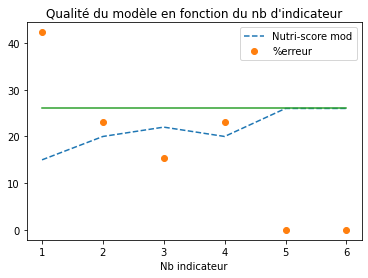

In [ ]:
x=np.array([1,2,3,4,5,6])
y=np.array([15,20,22,20,26,26])
err=(26-y)/26*100

import matplotlib.pyplot as plt
plt.plot(x,y,'--',label='Nutri-score mod')
plt.plot(x,err,'o',label='%erreur')
plt.plot([1,6],[26,26])
plt.title('Qualité du modèle en fonction du nb d\'indicateur')
plt.legend(loc='upper right')
plt.xlabel("Nb indicateur")